# First Goal Prediction Models

Now we have our data in a nice queryable format, we will form some basic models:
 - To build on with more 'relevant' features
 - To build the pipes for evaluating and comparing models (helper functions)

In [1]:
from IPython.display import display, Markdown

import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import poisson
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

from dspy.display import statsmodels_pretty_print, pp_conf_matrices, pp_conf_matrix
from dspy.preprocess_utils import apply_feature_scaling
from dspy.eval_utils import statsmodels_create_eval_df

from epl.features_parse import get_feat_col_names
from epl.feature_utils import home_away_to_team_opp, create_goal_probs, create_match_prediction_stats, create_poisson_prediction_output, eval_df_to_match_eval_df
from epl.query import create_and_query

pd.options.display.max_columns = None
warnings.filterwarnings('ignore')

## 1. Fetch Data

### 1a. Match Data

Need to import the raw match data and reformat so we have a row per team per match (rather than a row per match with 2 teams)

In [2]:
# get key cols for join to features along with useful id data and goal/result data
match_key_cols = ['Date', 'HomeTeam', 'AwayTeam']
id_cols = ['Country', 'Div', 'Season']
match_other_cols = ['FTHG', 'FTAG', 'FTR']

wc = {'Div': ['IN', ['E0', 'I1', 'SP1', 'D1', 'F1']]}

In [3]:
match_cols = match_key_cols + id_cols + match_other_cols
df_matches = create_and_query('matches', cols=match_cols, wc=wc)
df_matches.tail(5)

Running query: SELECT Date, HomeTeam, AwayTeam, Country, Div, Season, FTHG, FTAG, FTR FROM matches WHERE Div IN ('E0', 'I1', 'SP1', 'D1', 'F1')


,Date,HomeTeam,AwayTeam,Country,Div,Season,FTHG,FTAG,FTR
47884,2020-12-06,Alaves,Sociedad,spain,SP1,2021,0.0,0.0,D
47583,2020-12-07,Brighton,Southampton,england,E0,2021,1.0,2.0,A
47673,2020-12-07,Hoffenheim,Augsburg,germany,D1,2021,3.0,1.0,H
47772,2020-12-07,Fiorentina,Genoa,italy,I1,2021,1.0,1.0,D
47885,2020-12-07,Eibar,Valencia,spain,SP1,2021,0.0,0.0,D


### 1b. Create Train/Test Split At Match Level

Before we split into individual team per match format, we need to define train/test split so we estimate goals for complete matches

We do this by splitting pre-conversion and adding an extra col 'train'=True if training, else test

In [4]:
test_frac = 1/10
seed = 123

train_matches, test_matches = train_test_split(df_matches, test_size = test_frac, random_state=seed, stratify=df_matches['FTR'])

train_matches['Train'] = True
test_matches['Train'] = False

df_matches = pd.concat([train_matches, test_matches])

Now we convert so we have a row per team per match

In [5]:
print("Converting match df with {:,} rows of matches".format(len(df_matches)))
df_m = home_away_to_team_opp(df_matches)
print("Now have df with {:,} rows".format(len(df_m)))
df_m.tail()

Converting match df with 48,014 rows of matches
Now have df with 96,028 rows


,Date,Team,Opp,Country,Div,Season,FTR,Train,Home,GF,GA
47772,2020-12-07,Fiorentina,Genoa,italy,I1,2021,D,True,1,1.0,1.0
47772,2020-12-07,Genoa,Fiorentina,italy,I1,2021,D,True,0,1.0,1.0
47673,2020-12-07,Hoffenheim,Augsburg,germany,D1,2021,H,False,1,3.0,1.0
47583,2020-12-07,Southampton,Brighton,england,E0,2021,A,True,0,2.0,1.0
47885,2020-12-07,Valencia,Eibar,spain,SP1,2021,D,True,0,0.0,0.0


### 1b. Feature Data

Now we need to define which features we want

For now, we will pull in everything we have and then we can form various models below using different iterations of the data

In [6]:
df_feats = create_and_query('features', wc=wc)
df_feats.tail(5)

Running query: SELECT * FROM features WHERE Div IN ('E0', 'I1', 'SP1', 'D1', 'F1')


,Date,Team,Location,Country,Div,Season,AvgGF_3,AvgGA_3,AvgGFH_3,AvgGAH_3,AvgGFA_3,AvgGAA_3,AvgSF_3,AvgSA_3,AvgSFH_3,AvgSAH_3,AvgSFA_3,AvgSAA_3,AvgSTF_3,AvgSTA_3,AvgSTFH_3,AvgSTAH_3,AvgSTFA_3,AvgSTAA_3,AvgPPG_3,AvgPPGH_3,AvgPPGA_3,AvgGF_5,AvgGA_5,AvgGFH_5,AvgGAH_5,AvgGFA_5,AvgGAA_5,AvgSF_5,AvgSA_5,AvgSFH_5,AvgSAH_5,AvgSFA_5,AvgSAA_5,AvgSTF_5,AvgSTA_5,AvgSTFH_5,AvgSTAH_5,AvgSTFA_5,AvgSTAA_5,AvgPPG_5,AvgPPGH_5,AvgPPGA_5,AvgGF_10,AvgGA_10,AvgGFH_10,AvgGAH_10,AvgGFA_10,AvgGAA_10,AvgSF_10,AvgSA_10,AvgSFH_10,AvgSAH_10,AvgSFA_10,AvgSAA_10,AvgSTF_10,AvgSTA_10,AvgSTFH_10,AvgSTAH_10,AvgSTFA_10,AvgSTAA_10,AvgPPG_10,AvgPPGH_10,AvgPPGA_10,AvgGF_20,AvgGA_20,AvgGFH_20,AvgGAH_20,AvgGFA_20,AvgGAA_20,AvgSF_20,AvgSA_20,AvgSFH_20,AvgSAH_20,AvgSFA_20,AvgSAA_20,AvgSTF_20,AvgSTA_20,AvgSTFH_20,AvgSTAH_20,AvgSTFA_20,AvgSTAA_20,AvgPPG_20,AvgPPGH_20,AvgPPGA_20,AvgGF_40,AvgGA_40,AvgGFH_40,AvgGAH_40,AvgGFA_40,AvgGAA_40,AvgSF_40,AvgSA_40,AvgSFH_40,AvgSAH_40,AvgSFA_40,AvgSAA_40,AvgSTF_40,AvgSTA_40,AvgSTFH_40,AvgSTAH_40,AvgSTFA_40,AvgSTAA_40,AvgPPG_40,AvgPPGH_40,AvgPPGA_40
96025,2020-12-07,Hoffenheim,Home,germany,D1,2021,1.666667,2.000000,1.333333,2.333333,1.000000,1.333333,13.000000,14.666667,10.333333,14.666667,13.666667,9.666667,6.000000,7.0,5.333333,6.666667,5.333333,4.666667,0.666667,0.333333,0.666667,1.4,2.0,2.4,1.6,1.4,1.6,12.8,11.6,12.6,12.6,13.0,11.6,5.8,5.8,6.4,4.6,5.4,5.2,0.6,1.4,1.0,1.9,1.6,1.7,2.3,1.8,1.2,12.8,12.3,13.2,14.4,13.6,13.1,5.8,5.2,5.7,5.7,5.7,4.4,1.2,1.0,1.6,1.70,1.65,1.55,2.15,1.70,1.15,12.90,13.70,14.1,13.30,13.05,14.35,5.45,4.95,5.60,5.20,5.00,4.90,1.35,1.15,1.70,1.625,1.650,1.700,1.675,1.900,1.45,13.575,13.825,16.375,12.675,14.225,14.850,5.300,5.050,5.900,4.950,5.675,5.175,1.425,1.450,1.500
96023,2020-12-07,Fiorentina,Home,italy,I1,2021,0.000000,1.000000,1.333333,1.666667,0.000000,1.333333,5.333333,8.666667,8.333333,11.666667,4.666667,9.000000,3.333333,3.0,4.000000,6.666667,2.666667,4.000000,0.333333,1.000000,0.333333,0.6,1.4,1.8,1.0,1.0,2.0,4.6,9.6,11.4,9.8,5.8,9.0,2.8,4.4,5.8,5.2,3.6,4.0,0.8,1.8,0.4,1.3,1.6,1.4,1.0,1.4,1.5,9.1,9.3,11.6,8.3,8.0,9.3,4.9,4.8,5.8,4.9,4.8,4.6,1.1,1.5,1.2,1.40,1.30,1.10,1.10,1.40,1.55,9.50,9.15,11.0,8.10,8.65,10.00,5.15,4.80,5.25,4.85,5.15,5.30,1.30,1.25,1.15,1.225,1.325,1.125,1.125,1.350,1.45,9.875,9.000,10.950,7.750,9.675,9.950,5.250,5.075,5.200,4.500,5.575,5.200,1.150,1.175,1.100
96024,2020-12-07,Genoa,Away,italy,I1,2021,0.666667,2.000000,1.000000,2.333333,0.333333,0.666667,8.000000,10.666667,9.333333,10.333333,5.666667,11.333333,3.666667,6.0,4.666667,5.000000,2.333333,6.333333,0.000000,0.000000,0.666667,0.8,1.8,1.4,2.0,0.2,2.6,8.0,9.4,7.8,10.4,6.0,13.4,3.8,4.4,4.4,5.2,2.2,7.8,0.2,0.6,0.4,1.1,1.8,1.5,1.6,0.9,2.2,6.3,11.7,7.7,10.9,7.0,11.4,3.4,5.9,4.5,4.6,3.5,6.4,0.8,1.2,1.0,1.15,2.00,1.35,1.80,1.00,2.00,7.15,11.05,7.9,9.95,7.75,13.05,3.95,5.75,4.80,4.90,4.00,7.10,0.95,1.05,0.90,1.175,1.900,1.175,1.550,0.950,1.90,7.825,11.500,9.325,9.650,8.250,12.850,4.400,6.000,5.125,5.075,3.925,6.900,0.975,1.050,0.775
96022,2020-12-07,Eibar,Home,spain,SP1,2021,1.000000,0.333333,0.000000,0.666667,1.333333,0.333333,11.333333,9.666667,11.333333,7.333333,7.333333,14.000000,4.666667,4.0,4.666667,3.000000,3.333333,4.000000,1.666667,0.666667,2.333333,0.8,0.6,0.2,1.0,1.4,0.8,9.2,11.2,10.6,7.2,9.0,13.0,3.6,3.8,3.8,3.2,3.8,4.6,1.6,0.4,2.0,0.8,0.9,0.5,0.8,1.2,1.1,9.8,10.1,10.3,8.5,10.7,12.2,3.8,3.9,3.7,3.4,3.9,4.1,1.2,1.0,1.7,0.85,0.95,0.90,1.10,0.90,1.50,10.50,10.35,11.5,8.95,9.70,11.60,3.80,3.75,4.15,3.55,3.55,4.35,1.35,1.05,1.15,0.925,1.300,1.300,1.125,0.875,1.50,11.025,10.200,13.575,8.475,10.750,10.475,4.000,3.925,4.725,3.300,3.300,3.825,1.150,1.425,0.950
96027,2020-12-07,Valencia,Away,spain,SP1,2021,2.000000,1.333333,2.000000,1.333333,1.333333,2.000000,8.333333,14.333333,7.666667,15.333333,12.666667,10.666667,3.666667,5.0,3.666667,5.666667,4.000000,3.666667,1.333333,1.333333,0.333333,1.8,1.6,1.4,1.4,1.2,1.6,10.0,12.4,6.6,16.0,11.2,13.2,4.0,4.4,3.0,5.8,4.0,4.0,1.0,1.0,0.8,1.3,1.5,1.6,1.2,0.8,1.5,8.9,14.6,8.3,15.3,9.5,14.

## 2. Join Data

Now we have our matches and features, we need to join them together by:
 - Joining on for both Team and Opp
 - Joining on fixture relevant data i.e. if a team is at Home, join on their recent GFH instead of GFA data and vice versa

In [7]:
feat_id_cols = list(set(id_cols + ['Date', 'Team', 'Location']))

In [8]:
feat_cols = [x for x in df_feats.columns if x not in feat_id_cols]
print("We have {} feature cols to join for each of team and opp".format(len(feat_cols)))

We have 105 feature cols to join for each of team and opp


In [9]:
feat_join_key = ['Date', 'Team']

feat_cols_team = ['Team'+x for x in feat_cols]
df_feats_team = df_feats.rename(columns=dict(zip(feat_cols, feat_cols_team)))
team_cols = feat_join_key + feat_cols_team

feat_cols_opp = ['Opp'+x for x in feat_cols]
df_feats_opp = df_feats.rename(columns=dict(zip(feat_cols, feat_cols_opp)))
opp_cols = feat_join_key + feat_cols_opp

In [10]:
df = pd.merge(left=df_m, right=df_feats_team[team_cols], how='left', left_on=feat_join_key, right_on=feat_join_key)
df = pd.merge(left=df, right=df_feats_opp[opp_cols], how='left', left_on=['Date', 'Opp'], right_on=feat_join_key, suffixes=('', '_DROP'))
df = df.drop(columns=[x for x in df.columns if x[-5:] == '_DROP'])

In [11]:
df.tail()

,Date,Team,Opp,Country,Div,Season,FTR,Train,Home,GF,GA,TeamAvgGF_3,TeamAvgGA_3,TeamAvgGFH_3,TeamAvgGAH_3,TeamAvgGFA_3,TeamAvgGAA_3,TeamAvgSF_3,TeamAvgSA_3,TeamAvgSFH_3,TeamAvgSAH_3,TeamAvgSFA_3,TeamAvgSAA_3,TeamAvgSTF_3,TeamAvgSTA_3,TeamAvgSTFH_3,TeamAvgSTAH_3,TeamAvgSTFA_3,TeamAvgSTAA_3,TeamAvgPPG_3,TeamAvgPPGH_3,TeamAvgPPGA_3,TeamAvgGF_5,TeamAvgGA_5,TeamAvgGFH_5,TeamAvgGAH_5,TeamAvgGFA_5,TeamAvgGAA_5,TeamAvgSF_5,TeamAvgSA_5,TeamAvgSFH_5,TeamAvgSAH_5,TeamAvgSFA_5,TeamAvgSAA_5,TeamAvgSTF_5,TeamAvgSTA_5,TeamAvgSTFH_5,TeamAvgSTAH_5,TeamAvgSTFA_5,TeamAvgSTAA_5,TeamAvgPPG_5,TeamAvgPPGH_5,TeamAvgPPGA_5,TeamAvgGF_10,TeamAvgGA_10,TeamAvgGFH_10,TeamAvgGAH_10,TeamAvgGFA_10,TeamAvgGAA_10,TeamAvgSF_10,TeamAvgSA_10,TeamAvgSFH_10,TeamAvgSAH_10,TeamAvgSFA_10,TeamAvgSAA_10,TeamAvgSTF_10,TeamAvgSTA_10,TeamAvgSTFH_10,TeamAvgSTAH_10,TeamAvgSTFA_10,TeamAvgSTAA_10,TeamAvgPPG_10,TeamAvgPPGH_10,TeamAvgPPGA_10,TeamAvgGF_20,TeamAvgGA_20,TeamAvgGFH_20,TeamAvgGAH_20,TeamAvgGFA_20,TeamAvgGAA_20,TeamAvgSF_20,TeamAvgSA_20,TeamAvgSFH_20,TeamAvgSAH_20,TeamAvgSFA_20,TeamAvgSAA_20,TeamAvgSTF_20,TeamAvgSTA_20,TeamAvgSTFH_20,TeamAvgSTAH_20,TeamAvgSTFA_20,TeamAvgSTAA_20,TeamAvgPPG_20,TeamAvgPPGH_20,TeamAvgPPGA_20,TeamAvgGF_40,TeamAvgGA_40,TeamAvgGFH_40,TeamAvgGAH_40,TeamAvgGFA_40,TeamAvgGAA_40,TeamAvgSF_40,TeamAvgSA_40,TeamAvgSFH_40,TeamAvgSAH_40,TeamAvgSFA_40,TeamAvgSAA_40,TeamAvgSTF_40,TeamAvgSTA_40,TeamAvgSTFH_40,TeamAvgSTAH_40,TeamAvgSTFA_40,TeamAvgSTAA_40,TeamAvgPPG_40,TeamAvgPPGH_40,TeamAvgPPGA_40,OppAvgGF_3,OppAvgGA_3,OppAvgGFH_3,OppAvgGAH_3,OppAvgGFA_3,OppAvgGAA_3,OppAvgSF_3,OppAvgSA_3,OppAvgSFH_3,OppAvgSAH_3,OppAvgSFA_3,OppAvgSAA_3,OppAvgSTF_3,OppAvgSTA_3,OppAvgSTFH_3,OppAvgSTAH_3,OppAvgSTFA_3,OppAvgSTAA_3,OppAvgPPG_3,OppAvgPPGH_3,OppAvgPPGA_3,OppAvgGF_5,OppAvgGA_5,OppAvgGFH_5,OppAvgGAH_5,OppAvgGFA_5,OppAvgGAA_5,OppAvgSF_5,OppAvgSA_5,OppAvgSFH_5,OppAvgSAH_5,OppAvgSFA_5,OppAvgSAA_5,OppAvgSTF_5,OppAvgSTA_5,OppAvgSTFH_5,OppAvgSTAH_5,OppAvgSTFA_5,OppAvgSTAA_5,OppAvgPPG_5,OppAvgPPGH_5,OppAvgPPGA_5,OppAvgGF_10,OppAvgGA_10,OppAvgGFH_10,OppAvgGAH_10,OppAvgGFA_10,OppAvgGAA_10,OppAvgSF_10,OppAvgSA_10,OppAvgSFH_10,OppAvgSAH_10,OppAvgSFA_10,OppAvgSAA_10,OppAvgSTF_10,OppAvgSTA_10,OppAvgSTFH_10,OppAvgSTAH_10,OppAvgSTFA_10,OppAvgSTAA_10,OppAvgPPG_10,OppAvgPPGH_10,OppAvgPPGA_10,OppAvgGF_20,OppAvgGA_20,OppAvgGFH_20,OppAvgGAH_20,OppAvgGFA_20,OppAvgGAA_20,OppAvgSF_20,OppAvgSA_20,OppAvgSFH_20,OppAvgSAH_20,OppAvgSFA_20,OppAvgSAA_20,OppAvgSTF_20,OppAvgSTA_20,OppAvgSTFH_20,OppAvgSTAH_20,OppAvgSTFA_20,OppAvgSTAA_20,OppAvgPPG_20,OppAvgPPGH_20,OppAvgPPGA_20,OppAvgGF_40,OppAvgGA_40,OppAvgGFH_40,OppAvgGAH_40,OppAvgGFA_40,OppAvgGAA_40,OppAvgSF_40,OppAvgSA_40,OppAvgSFH_40,OppAvgSAH_40,OppAvgSFA_40,OppAvgSAA_40,OppAvgSTF_40,OppAvgSTA_40,OppAvgSTFH_40,OppAvgSTAH_40,OppAvgSTFA_40,OppAvgSTAA_40,OppAvgPPG_40,OppAvgPPGH_40,OppAvgPPGA_40
96023,2020-12-07,Fiorentina,Genoa,italy,I1,2021,D,True,1,1.0,1.0,0.000000,1.000000,1.333333,1.666667,0.000000,1.333333,5.333333,8.666667,8.333333,11.666667,4.666667,9.000000,3.333333,3.000000,4.000000,6.666667,2.666667,4.000000,0.333333,1.000000,0.333333,0.6,1.4,1.8,1.0,1.0,2.0,4.6,9.6,11.4,9.8,5.8,9.0,2.8,4.4,5.8,5.2,3.6,4.0,0.8,1.8,0.4,1.3,1.6,1.4,1.0,1.4,1.5,9.1,9.3,11.6,8.3,8.0,9.3,4.9,4.8,5.8,4.9,4.8,4.6,1.1,1.5,1.2,1.40,1.30,1.10,1.10,1.40,1.55,9.50,9.15,11.00,8.10,8.65,10.00,5.15,4.80,5.25,4.85,5.15,5.30,1.30,1.25,1.15,1.225,1.325,1.125,1.125,1.35,1.450,9.875,9.000,10.950,7.750,9.675,9.950,5.250,5.075,5.200,4.500,5.575,5.200,1.150,1.175,1.100,0.666667,2.000000,1.000000,2.333333,0.333333,0.666667,8.000000,10.666667,9.333333,10.333333,5.666667,11.333333,3.666667,6.000000,4.666667,5.000000,2.333333,6.333333,0.000000,0.000000,0.666667,0.8,1.8,1.4,2.0,0.2,2.6,8.0,9.4,7.8,10.4,6.0,13.4,3.8,4.4,4.4,5.2,2.2,7.8,0.2,0.6,0.4,1.1,1.8,1.5,1.6,0.9,2.2,6.3,11.7,7.7,10.9,7.0,11.4,3.4,5.9,4.5,4.6,3.5,6.4,0.8,1.2,1.0,1.15,2.00,1.35,1.80,1.00,2.00,7.15,11.05,7.90,9.95,7.75,13.05,3.95,5.75,4.80,4.90,4.00,7.10,0.95,1.05,0.90,1.175,1.900,1.175,1.550,0.950,1.900,7.825,11

## 3. Simple First Model - Always Home

As a first attempt, let's have a look at home advantage

We can build this in a few ways:
 - Simple prediction as 'H' for result always
 - Build a 'model' just to test and automate the model eval process
 
Will do the later so we can play with statsmodels

### 3a. Select and Prepare $X,y$ Data

Given 'Home' will be the only factor in the model, would anticipate a poisson model for goals scored will always spit out a higher distribution for home goals --> and therefore out of ['A', 'D', 'H'], 'H' will always have the highest probability

__Select Data__

In [41]:
pred_col = 'GF'

train_col = ['Train']
feats = ['Home']
stand_feats = ['TeamAvgGF_5', 'TeamAvgGA_5',
               'OppAvgGF_5', 'OppAvgGA_5',
               'TeamAvgSF_5', 'TeamAvgSTF_5',
               'OppAvgSA_5', 'OppAvgSTA_5',
               
               'TeamAvgGF_10', 'TeamAvgGA_10',
               'OppAvgGF_10', 'OppAvgGA_10',
               'TeamAvgSF_10', 'TeamAvgSTF_10',
               'OppAvgSA_10', 'OppAvgSTA_10',
               
               'TeamAvgGF_40', 'TeamAvgGA_40',
               'OppAvgGF_40', 'OppAvgGA_40',
               'TeamAvgSF_40', 'TeamAvgSTF_40',
               'OppAvgSA_40', 'OppAvgSTA_40']
norm_feats = []
all_feats = feats + stand_feats + norm_feats

df_est = df[[pred_col] + train_col + all_feats].dropna()
print('From original df with {:,} obs, have dropped {:,} NaNs'.format(len(df), len(df) - len(df_est)))
df_est.tail()

From original df with 96,028 obs, have dropped 51,080 NaNs


,GF,Train,Home,TeamAvgGF_5,TeamAvgGA_5,OppAvgGF_5,OppAvgGA_5,TeamAvgSF_5,TeamAvgSTF_5,OppAvgSA_5,OppAvgSTA_5,TeamAvgGF_10,TeamAvgGA_10,OppAvgGF_10,OppAvgGA_10,TeamAvgSF_10,TeamAvgSTF_10,OppAvgSA_10,OppAvgSTA_10,TeamAvgGF_40,TeamAvgGA_40,OppAvgGF_40,OppAvgGA_40,TeamAvgSF_40,TeamAvgSTF_40,OppAvgSA_40,OppAvgSTA_40
96023,1.0,True,1,0.6,1.4,0.8,1.8,4.6,2.8,9.4,4.4,1.3,1.6,1.1,1.8,9.1,4.9,11.7,5.9,1.225,1.325,1.175,1.900,9.875,5.250,11.500,6.000
96024,1.0,True,0,0.8,1.8,0.6,1.4,8.0,3.8,9.6,4.4,1.1,1.8,1.3,1.6,6.3,3.4,9.3,4.8,1.175,1.900,1.225,1.325,7.825,4.400,9.000,5.075
96025,3.0,False,1,1.4,2.0,1.2,1.8,12.8,5.8,12.0,5.6,1.9,1.6,1.2,1.4,12.8,5.8,13.5,5.5,1.625,1.650,1.300,1.650,13.575,5.300,13.875,4.925
96026,2.0,True,0,2.2,1.4,1.0,1.0,10.6,5.0,8.6,2.6,1.9,1.6,1.4,1.6,10.7,5.1,7.8,2.8,1.550,1.525,1.125,1.500,12.500,4.950,12.000,4.100
96027,0.0,True,0,1.8,1.6,0.8,0.6,10.0,4.0,11.2,3.8,1.3,1.5,0.8,0.9,8.9,3.5,10.1,3.9,1.250,1.425,0.925,1.300,8.625,3.225,10.200,3.925


__Split Data into train/test__

In [42]:
X = df_est[all_feats]
y = df_est[pred_col]

x_train = df_est[df_est.Train][all_feats]
x_test = df_est[~df_est.Train][all_feats]

y_train = df_est[df_est.Train][pred_col]
y_test = df_est[~df_est.Train][pred_col]

print('Using {:,} cases for training'.format(x_train.shape[0]))
print('---')
print('Using {:,} cases for testing'.format(x_test.shape[0]))
print('---')
print('Using following factors to predict: {}'.format(', '.join(all_feats)))

Using 40,514 cases for training
---
Using 4,434 cases for testing
---
Using following factors to predict: Home, TeamAvgGF_5, TeamAvgGA_5, OppAvgGF_5, OppAvgGA_5, TeamAvgSF_5, TeamAvgSTF_5, OppAvgSA_5, OppAvgSTA_5, TeamAvgGF_10, TeamAvgGA_10, OppAvgGF_10, OppAvgGA_10, TeamAvgSF_10, TeamAvgSTF_10, OppAvgSA_10, OppAvgSTA_10, TeamAvgGF_40, TeamAvgGA_40, OppAvgGF_40, OppAvgGA_40, TeamAvgSF_40, TeamAvgSTF_40, OppAvgSA_40, OppAvgSTA_40


__Scale Features (if required)__

In [43]:
x_train, std_scaler, norm_scaler = apply_feature_scaling(x_train, stand_feats, norm_feats)

### 3b. Fit and Inspect Model Output

In [44]:
# boolean to decide to add intercept term (sklearn does by default)
add_int = True
# create a Poisson GLM class
poisson_model = sm.GLM(y_train, (sm.add_constant(x_train) if add_int else x_train), family=sm.families.Poisson())
# fit the model
model = poisson_model.fit()

In [45]:
model_output = statsmodels_pretty_print(model, alpha=0.05, dp=2, model_overview=True, param_sort_cols=['Sig', 'coef'])
model_output


__Estimating a Poisson GLM model__
<br>
__Model Overview__
<br>
Assume underlying discrete variable $z_i$ has a poisson distribution - we want to estimate for a set of data $[y_i, X_i]$ what this $\lambda_i$ should be
<br>
Utilising the $e$ to ensure $\lambda>0$ we thus have the following model specification:
<br>
$$\lambda_i = e^{\alpha + \beta X_i}$$
<br>
Utilising a log link function we thus use MLE to estimate the following equation:
<br>
$$ln(\lambda_i) = \alpha + \beta X_i$$
Solving steps:
- Estimate values for $\alpha$ and $\beta$
- Using data for $X_i$ obtain estimates for $\lambda_i$
- Use these to generate $P(z_i = k | \lambda_i)$ for all observations
- Use max likelihood function to see how we did - then iterate on $\alpha$ and $\beta$ to maximise likelihood function


__Model Output__

,coef,lb,ub,p,z,Sig,coef_mag
Home,1.36,1.33,1.38,0.00,35.01,True,0.36
TeamAvgGF_40,1.12,1.10,1.14,0.00,12.21,True,0.12
const,1.10,1.09,1.12,0.00,14.49,True,0.10
OppAvgGA_40,1.09,1.07,1.10,0.00,10.95,True,0.09
OppAvgGF_40,0.96,0.95,0.97,0.00,-5.41,True,0.04
TeamAvgSF_40,1.03,1.01,1.05,0.02,2.40,True,0.03
TeamAvgGA_40,0.97,0.96,0.99,0.00,-4.18,True,0.03
OppAvgSA_5,1.03,1.00,1.05,0.02,2.35,True,0.03
OppAvgGF_10,0.98,0.96,1.00,0.02,-2.37,True,0.02
OppAvgSTA_10,1.03,1.00,1.06,0.05,1.96,False,0.03


In [46]:
display(Markdown("Home advantage exists - model says Home Team {:.2f}x more likely to score (and very statistically significant)".format(model_output['coef']['Home'])))

display(Markdown("Can compare model outputs to training data averages for verification:"))

Home advantage exists - model says Home Team 1.36x more likely to score (and very statistically significant)

Can compare model outputs to training data averages for verification:

In [47]:
train_avgs = pd.concat([y_train, x_train], axis=1).groupby(['Home']).mean()
train_avgs

,GF,TeamAvgGF_5,TeamAvgGA_5,OppAvgGF_5,OppAvgGA_5,TeamAvgSF_5,TeamAvgSTF_5,OppAvgSA_5,OppAvgSTA_5,TeamAvgGF_10,TeamAvgGA_10,OppAvgGF_10,OppAvgGA_10,TeamAvgSF_10,TeamAvgSTF_10,OppAvgSA_10,OppAvgSTA_10,TeamAvgGF_40,TeamAvgGA_40,OppAvgGF_40,OppAvgGA_40,TeamAvgSF_40,TeamAvgSTF_40,OppAvgSA_40,OppAvgSTA_40
Home,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.155502,0.033117,-0.036305,-0.033117,0.036305,0.049441,0.034633,0.046648,0.034324,0.017755,-0.02144,-0.017755,0.02144,0.028549,0.01803,0.02423,0.017243,0.00545,-0.008524,-0.00545,0.008524,0.008981,0.004958,0.007613,0.005925
1,1.542578,-0.033117,0.036305,0.033117,-0.036305,-0.049441,-0.034633,-0.046648,-0.034324,-0.017755,0.02144,0.017755,-0.02144,-0.028549,-0.01803,-0.02423,-0.017243,-0.00545,0.008524,0.00545,-0.008524,-0.008981,-0.004958,-0.007613,-0.005925


In [48]:
display(Markdown(
'''We can see that:
 - The mean away goals is {:.2f} --> lines up with the 'const' coef
 - The mean home goals is {:.2f} --> lines up with {:.2f} * {:.2f} = {:.2f}
 
So our simple model matches _on average_ the data it was trained on (a good start)
'''.format(train_avgs.values[0][0], train_avgs.values[1][0], model_output['coef']['const'], model_output['coef']['Home'], model_output['coef']['Home'] * model_output['coef']['const'])
))

We can see that:
 - The mean away goals is 1.16 --> lines up with the 'const' coef
 - The mean home goals is 1.54 --> lines up with 1.10 * 1.36 = 1.50
 
So our simple model matches _on average_ the data it was trained on (a good start)


### 3c. Convert Poisson $\lambda$ to FTR Prediction

__Form Eval Dataframe__

In [56]:
eval_df = statsmodels_create_eval_df('test', model, add_int, X, y, x_train, x_test, y_train, y_test, stand_feats, norm_feats, std_scaler, norm_scaler)

Now we convert lambda into a goal distribution per team per match

__Create Goal and FTR Predictions__

In [57]:
eval_df = create_poisson_prediction_output(eval_df, df, ['Country', 'Div', 'Season', 'Train'])
eval_df = eval_df.sort_values(['Date', 'Country', 'Div'])

### 3d. Evaluate Model

Now we have our model predictions and true values together, we can eval

__Accuracy Metrics__

In [58]:
list_of_act_preds = [
    {'act': eval_df[eval_df['Train']]['FTR'],
     'pred': eval_df[eval_df['Train']]['FTRPred'],
     'label': 'Train'
    },
    {'act': eval_df[~eval_df['Train']]['FTR'],
     'pred': eval_df[~eval_df['Train']]['FTRPred'],
     'label': 'Test'
    },
    {'act': eval_df['FTR'],
     'pred': eval_df['FTRPred'],
     'label': 'All'
    }
]

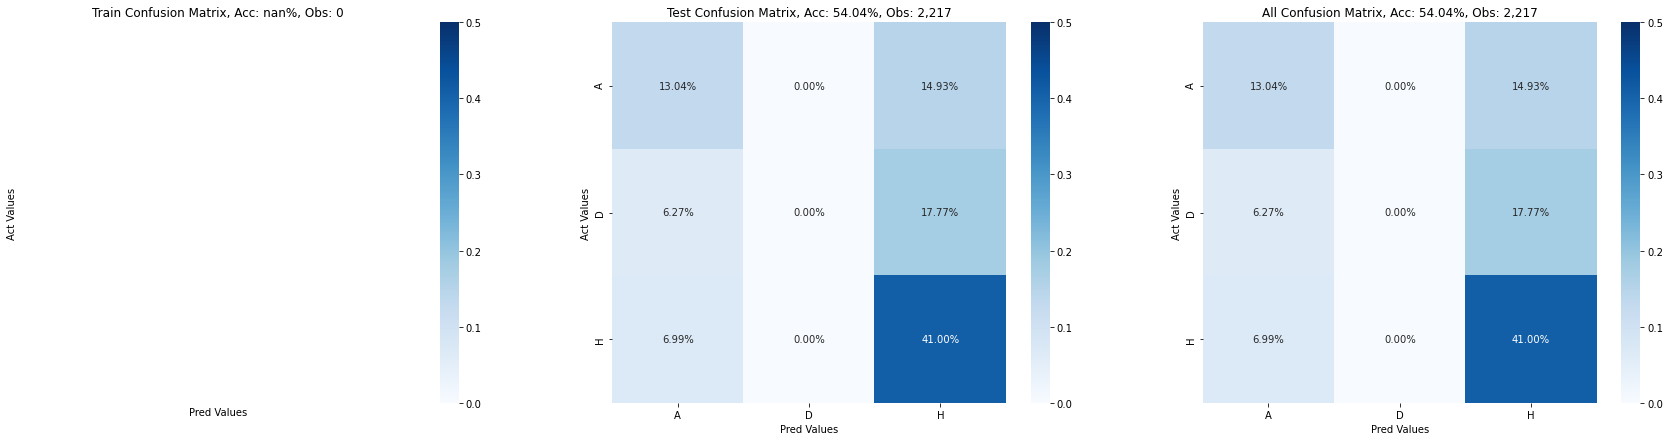

In [59]:
pp_conf_matrices(list_of_act_preds, max_val=0.5)

Given we have a simple 1 factor model for 'Home' only it is not surprising:
 - We only ever predict home due to the higher lambda for all home games
 - Home advantage holds for approx ~45% of games which is the accuracy of the model

This gives us a baseline --> ~45% is the min required to beat a naive model that only predicts home

__Accuracy by Score__

Can now try to bucket accuracy by scoreline

In [60]:
eval_score_df = eval_df[['FTR', 'FTRPred', 'FTHG', 'FTAG']]
eval_score_df['Correct'] = eval_score_df['FTR'] == eval_score_df['FTRPred']

In [61]:
acc_by_score = eval_score_df[['Correct','FTHG', 'FTAG']].groupby(['FTHG', 'FTAG']).sum() / eval_score_df[['Correct','FTHG', 'FTAG']].groupby(['FTHG', 'FTAG']).count()

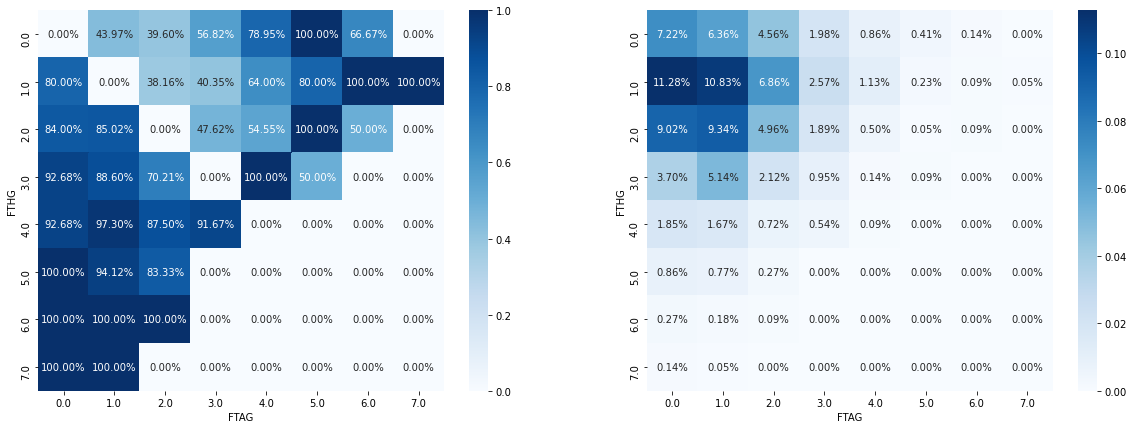

In [62]:
fig, axes = plt.subplots(ncols=2, figsize=(20,7))

sns.heatmap(pd.pivot_table(acc_by_score, index='FTHG', columns='FTAG', values='Correct').fillna(0), cmap='Blues', fmt='.2%', annot=True, ax=axes[0]);
sns.heatmap(pd.pivot_table(eval_score_df[['Correct','FTHG', 'FTAG']].groupby(['FTHG', 'FTAG']).count() / eval_score_df.shape[0], index='FTHG', columns='FTAG', values='Correct').fillna(0), cmap='Blues', fmt='.2%', annot=True, ax=axes[1]);

In [63]:
print("Our model All Accuracy: {:.2%}".format(sum(eval_df['FTR'] == eval_df['FTRPred']) / len(eval_df)))

print("Home model All Accuracy: {:.2%}".format(sum(eval_df['FTR'] == 'H') / len(eval_df)))

Our model All Accuracy: 54.04%
Home model All Accuracy: 47.99%


Extensions:
 - Functionalise the Poisson GLM and model eval process:
  - Most likely score matrix --> some comparison to see what is over/under-estimated
 - Can then start to look at above metrics when split by:
  - Accuracy by Div / Country
 
 
 
 - Function to query and invert B365 over / under odds into poisson $\lambda$ for comparion
  
 - Some weighting for the quality of goals scored i.e. score 5 goals vs a team who usually concedes 1, better than usually concedes 5
 - Play with grid search